HW

In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import decomposition
from sklearn import preprocessing
from functions import *
from scipy.stats import shapiro
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# nutrition_grade_fr

In [2]:
data = pd.read_csv("fr.openfoodfacts.org.products.csv", sep='\t', error_bad_lines=False, low_memory=False) # raw dataset

data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,0000000016087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,0000000016094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###  Exploration préliminaire

In [3]:
print(f'Le dataframe brut comporte {data.shape[0]} éléments et {data.shape[1]} colonnes.')

Le dataframe brut comporte 320772 éléments et 162 colonnes.


In [4]:
nutrition = ["energy_100g","fat_100g","carbohydrates_100g", "fiber_100g","proteins_100g","sodium_100g", "saturated-fat_100g",
             "trans-fat_100g", "cholesterol_100g", "sugars_100g", "salt_100g", "vitamin-a_100g", "vitamin-c_100g",
             "calcium_100g", "iron_100g", "nutrition-score-fr_100g"]

maxvalue = {"energy_100g":3766,
            "fat_100g":100,
            "carbohydrates_100g":100,
            "fiber_100g":100,
            "proteins_100g":100,
            "sodium_100g":100,
            "saturated-fat_100g":100,
            "trans-fat_100g":100,
            "cholesterol_100g":100,
            "sugars_100g":100,
            "salt_100g":100,
            "vitamin-a_100g":100,
            "vitamin-c_100g":100,
            "calcium_100g":100,
            "iron_100g":100}

for nutr in nutrition:
    print('\n')
    print(data[nutr].describe())



count    2.611130e+05
mean     1.141915e+03
std      6.447154e+03
min      0.000000e+00
25%      3.770000e+02
50%      1.100000e+03
75%      1.674000e+03
max      3.251373e+06
Name: energy_100g, dtype: float64


count    243891.000000
mean         12.730379
std          17.578747
min           0.000000
25%           0.000000
50%           5.000000
75%          20.000000
max         714.290000
Name: fat_100g, dtype: float64


count    243588.000000
mean         32.073981
std          29.731719
min           0.000000
25%           6.000000
50%          20.600000
75%          58.330000
max        2916.670000
Name: carbohydrates_100g, dtype: float64


count    200886.000000
mean          2.862111
std          12.867578
min          -6.700000
25%           0.000000
50%           1.500000
75%           3.600000
max        5380.000000
Name: fiber_100g, dtype: float64


count    259922.000000
mean          7.075940
std           8.409054
min        -800.000000
25%           0.700000
50%     

### Nettoyage des données

In [5]:
# sampling rows containing not null nutrition data
for col in nutrition:
    data = data[data[col].notnull()]

# calculating default replacement value for each column
default_value = []
for col in maxvalue:
    data = data[data[col].notnull()]
    stats = data[col].describe()
    q1 = stats.loc["25%"]
    q3 = stats.loc["75%"]
    default_value.append(q3 + 1.5 * (q3 - q1))
    
# replacing aberrant & missing values in parent dataframe
for index, row in data.iterrows():
    for col, default in zip(maxvalue, default_value):
        if row[col] > maxvalue[col]:
            data.at[index, col] = default
        elif row[col] < 0:
            data.at[index, col] = 0

# droping columns filled less than half
entries = data.shape[0]
for col in data.columns: 
    missing_values = data[col].isnull().sum()
    if missing_values > entries / 2 and col != 'categories':
        data = data.drop([col],axis=1)

### Bilan

In [6]:
print(f'Elements restants après traitement: {data.shape[0]}. Colonnes: {data.shape[1]}. Doublons: {data.shape[0]-len(data["code"].unique())}\n')
for col in data.columns:
    print(f"{col} {data[col].isnull().sum()}")

Elements restants après traitement: 126397. Colonnes: 43. Doublons: 0

code 0
url 0
creator 0
created_t 0
created_datetime 0
last_modified_t 0
last_modified_datetime 0
product_name 110
brands 721
brands_tags 721
categories 125371
countries 0
countries_tags 0
countries_fr 0
ingredients_text 287
serving_size 4
additives_n 287
additives 292
additives_tags 42566
additives_fr 42566
ingredients_from_palm_oil_n 287
ingredients_that_may_be_from_palm_oil_n 287
nutrition_grade_fr 0
states 0
states_tags 0
states_fr 0
energy_100g 0
fat_100g 0
saturated-fat_100g 0
trans-fat_100g 0
cholesterol_100g 0
carbohydrates_100g 0
sugars_100g 0
fiber_100g 0
proteins_100g 0
salt_100g 0
sodium_100g 0
vitamin-a_100g 0
vitamin-c_100g 0
calcium_100g 0
iron_100g 0
nutrition-score-fr_100g 0
nutrition-score-uk_100g 0


### ACP

In [7]:
def make_acp(list_of_cols):
    # choix du nombre de composantes à calculer
    n_comp = len(list_of_cols)
    print(f"Using {n_comp} composants")
    
    # selection des colonnes à prendre en compte dans l'ACP
    data_pca = data[list_of_cols]
    X = data_pca.values
    features = data_pca.columns
    
    # affichage de la matrice de corrélation
    d = pd.DataFrame(data=data, columns=list_of_cols)
    corr = d.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
    square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()
    
    # Centrage et Réduction
    std_scale = preprocessing.StandardScaler().fit(X)
    X_scaled = std_scale.transform(X)

    # Calcul des composantes principales
    pca = decomposition.PCA(n_components=n_comp)
    pca.fit(X_scaled)

    # Eboulis des valeurs propres
    display_scree_plot(pca)

    # Cercle des corrélations
    pcs = pca.components_
    display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))
    
    plt.show()


Using 11 composants


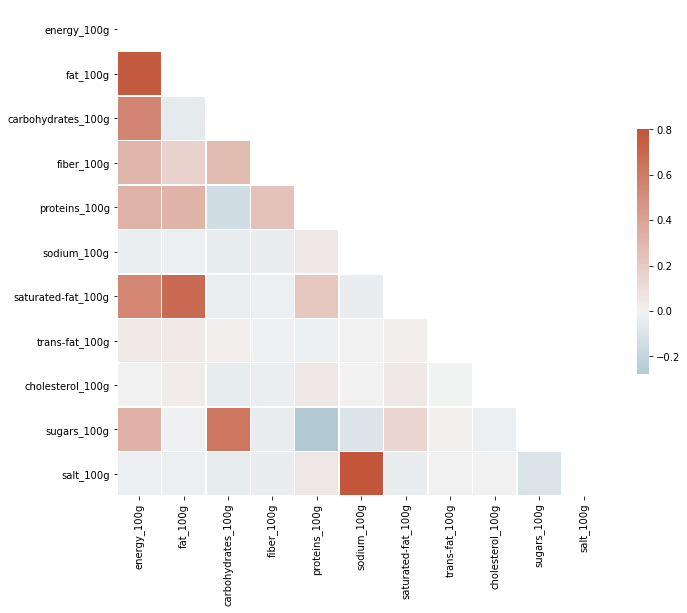

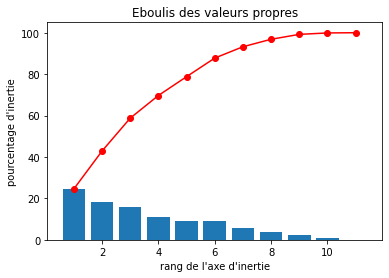

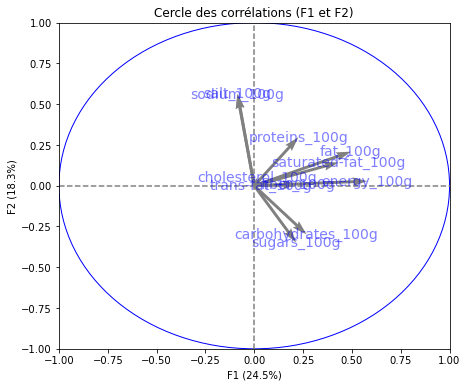

In [8]:
test_cols = ["energy_100g","fat_100g","carbohydrates_100g", "fiber_100g","proteins_100g","sodium_100g", "saturated-fat_100g",
             "trans-fat_100g", "cholesterol_100g", "sugars_100g", "salt_100g"]
make_acp(test_cols)

Using 16 composants


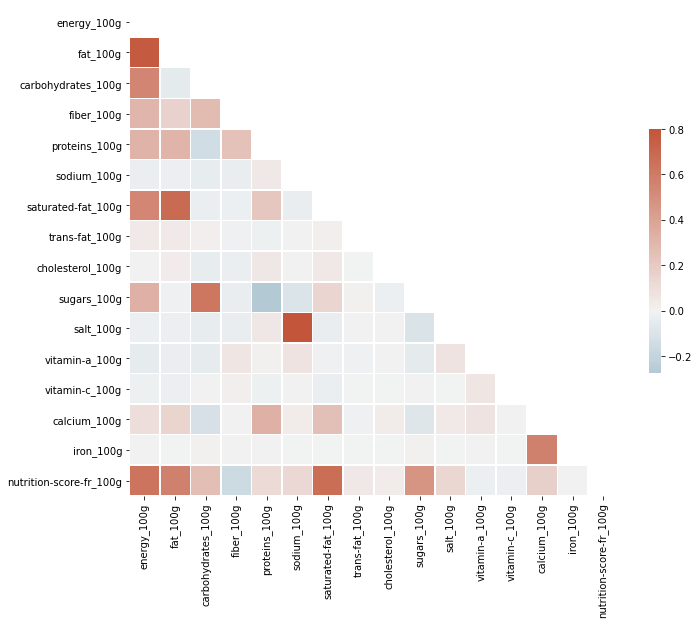

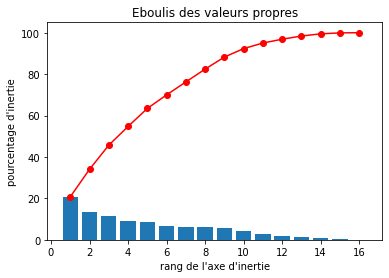

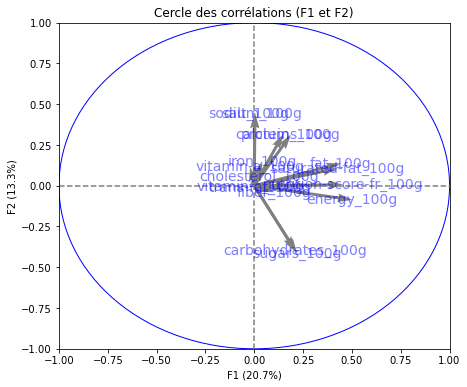

In [9]:
make_acp(nutrition)

### ANOVA

In [18]:
# test de normalité
def show_normal(nutriment):
    sns.displot(data[nutriment], kde=True)
    plt.show()
    
def normalcheck(nutriment):
    print(data[nutriment].describe())
    print('\n')
    print(shapiro(data[nutriment]))
    

In [19]:
def eta_squared(x,y):
    moyenne_y = y.mean()
    classes = []
    for classe in x.unique():
        yi_classe = y[x==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    SCT = sum([(yj-moyenne_y)**2 for yj in y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT


def nutrianova(nutriment): 
    X = "nutrition_grade_fr" # qualitative
    Y = nutriment # quantitative
    sous_echantillon = data[data[X].notnull()][data[Y].notnull()]
    print('\n')
    print(eta_squared(sous_echantillon[X],sous_echantillon[Y]))
    

In [20]:
interact(lambda x:show_normal(x), x=nutrition)

interactive(children=(Dropdown(description='x', options=('energy_100g', 'fat_100g', 'carbohydrates_100g', 'fib…

<function __main__.<lambda>(x)>

In [21]:
nut = nutrition[1]
normalcheck(nut)
nutrianova(nut)

count    126397.000000
mean         13.394196
std          15.494271
min           0.000000
25%           0.820000
50%           7.780000
75%          21.430000
max         100.000000
Name: fat_100g, dtype: float64


(0.8226140141487122, 0.0)




c:\users\skr\miniconda3\lib\site-packages\scipy\stats\morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.31656631633254134
